#### Objetivo: generar un modelo que pueda hacer predicciones de ventas

#### Escenario: Eres un científico de datos dentro de la consultoría “El oráculo”, tienes la asignación de trabajar en una empresa de retail para predecir sus ventas semanales a diferentes niveles muestrales, a nivel tienda

#### Datasource: https://www.kaggle.com/code/aslanahmedov/walmart-sales-forecasting

#### Entrega: 06 de Agosto de 2022



# 1. Import Libraries

In [146]:
import pandas as pd
import numpy as np
from prophet import Prophet
import plotly.express as px
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARMA

# 2. Read Data

In [3]:
df = pd.read_csv('c:/Users/mike_/Documents/repos/walmart_forecast/data/clean_data.csv', parse_dates=['Date'])
#df = pd.read_csv('https://raw.githubusercontent.com/lebesguee/walmart_forecast/main/data/clean_data.csv',\
 #               parse_dates=['Date']) # read online

## leer desde google drive: codigo en repo

# 2. EDA

In [4]:
#TO DO: Add PowerBI Viz 

In [5]:
#print('rows =', df.shape[0], ', columns =' ,df.shape[1]) # dataset shape
#df.columns #dataset columns
#df.sample(10) #df sample size 10
#df.info() # datatypes and null count
#df['Unnamed: 0'].duplicated().sum() # The Unnamed: 0 is the ID, no duplicates are expected
#df[df.duplicated('Unnamed: 0')] # no duplicates in ID confirmed
#df.describe() #quick stats summary

In [6]:
round(df.isnull().sum().sort_values(ascending=False)*100/len(df), 4) # Porcentaje Descendente de Nulos por Columna
#df.isnull().sum().sort_values(ascending=False) # Conteo Descendente de Nulos por Columna

Unnamed: 0      0.0
Store           0.0
month           0.0
week            0.0
Christmas       0.0
Thanksgiving    0.0
Labor_Day       0.0
Super_Bowl      0.0
Size            0.0
Type            0.0
Unemployment    0.0
CPI             0.0
MarkDown5       0.0
MarkDown4       0.0
MarkDown3       0.0
MarkDown2       0.0
MarkDown1       0.0
Fuel_Price      0.0
Temperature     0.0
IsHoliday       0.0
Weekly_Sales    0.0
Date            0.0
Dept            0.0
year            0.0
dtype: float64

# 3. Tables Creation

### 3.1 Tabla: Total de Ventas por Tienda

In [7]:
TOTAL_SALES_BY_STORE = df.groupby('Store', sort=False)["Weekly_Sales"].sum().reset_index(name ='Total_Sales')
#TOTAL_SALES_BY_STORE.head(10)

# Uncomment to get Table in Currency Format
#TOTAL_SALES_BY_STORE_STR = df.groupby('Store', sort=False)["Weekly_Sales"].sum().reset_index(name ='Total_Sales')
#TOTAL_SALES_BY_STORE_STR['Total_Sales'] = TOTAL_SALES_BY_STORE['Total_Sales'].map("${:,.2f}".format) # formato moneda
#TOTAL_SALES_BY_STORE_STR.head(10)

TOP10_SALES_STORES = TOTAL_SALES_BY_STORE.sort_values(by=['Total_Sales'], ascending=False).reset_index(drop=True).head(10)
TOP1_SALES_STORE = TOTAL_SALES_BY_STORE.sort_values(by=['Total_Sales'], ascending=False).reset_index(drop=True).head(1) # top n=1 tiendas con más ventas
TOP1_SALES_STORE['Total_Sales'] = TOP1_SALES_STORE['Total_Sales'].map("${:,.2f}".format)
TOP1_SALES_STORE

,Store,Total_Sales
0,20,"$301,401,381.45"


### 3.2 Tablas: Varianza por Tienda y Desviación Estándar por Tienda

In [8]:
VARIANCE_BY_STORE = df.groupby('Store', sort=False)["Weekly_Sales"].var().reset_index(name ='Sales_Variance')
STD_BY_STORE = df.groupby('Store', sort=False)["Weekly_Sales"].std().reset_index(name ='Sales_STD')# efectivo: sacar raiz a varianza

#VARIANCE_BY_STORE.head(10)
#STD_BY_STORE.head(10)

TOP1_STD_BY_STORE = STD_BY_STORE.sort_values(by=['Sales_STD'], ascending=False).reset_index(drop=True).head(1) # top n=1 tiendas con más ventas
TOP1_STD_BY_STORE['Sales_STD'] = TOP1_STD_BY_STORE['Sales_STD'].map("${:,.2f}".format)
TOP1_STD_BY_STORE

,Store,Sales_STD
0,14,"$36,936.12"


### 3.3 Coeficiente de Variación Medio

In [9]:
cv = lambda x: np.std(x.values) / np.mean(x.values) * 100
CV_BY_STORE = df[["Store","Weekly_Sales"]].groupby("Store").apply(cv).reset_index(name ='Coefficient_of_Variation')

TOP10_CV_BY_STORE = CV_BY_STORE.sort_values(by=['Coefficient_of_Variation'], ascending=False).reset_index(drop=True).head(10) # top n=1 tiendas con más ventas
TOP10_CV_BY_STORE['Coefficient_of_Variation'] = TOP10_CV_BY_STORE['Coefficient_of_Variation'].map("${:,.2f}".format)
TOP10_CV_BY_STORE

#CV_BY_STORE['Coefficient_of_Variation'].mean() # Promedio de Coeficiente de Variación

,Store,Coefficient_of_Variation
0,3,$331.28
1,44,$265.03
2,38,$258.57
3,30,$251.08
4,5,$246.31
5,42,$244.80
6,37,$243.93
7,33,$241.23
8,43,$239.68
9,36,$234.56


### 3.4 Vista Mensual, Trimestral y Semestral de Ventas Totales y por Tienda 

In [10]:
TOTAL_SALES_BY_MONTH = pd.DataFrame(df.set_index('Date')['Weekly_Sales'].resample('M').sum().reset_index(name ='Monthly_Sales'))
TOTAL_SALES_BY_QUARTER = pd.DataFrame(df.set_index('Date')['Weekly_Sales'].resample('Q').sum().reset_index(name ='Quarterly_Sales'))
TOTAL_SALES_BY_SEMESTER = pd.DataFrame(df.set_index('Date')['Weekly_Sales'].resample('2BQ').sum().reset_index(name ='Semester_Sales'))

#TOTAL_SALES_BY_MONTH.head(10)
#TOTAL_SALES_BY_QUARTER.head(10)
#TOTAL_SALES_BY_SEMESTER.head(10)

MONTHLY_SALES_BY_STORE = df.set_index("Date").groupby([pd.Grouper(freq="M"), "Store"])['Weekly_Sales'].sum().reset_index().rename(columns = {'Weekly_Sales':'Total_Sales'})
QUARTERLY_SALES_BY_STORE = df.set_index("Date").groupby([pd.Grouper(freq="Q"), "Store"])['Weekly_Sales'].sum().reset_index().rename(columns = {'Weekly_Sales':'Total_Sales'})
SEMESTER_SALES_BY_STORE = df.set_index("Date").groupby([pd.Grouper(freq="2BQ"), "Store"])['Weekly_Sales'].sum().reset_index().rename(columns = {'Weekly_Sales':'Total_Sales'})

#MONTHLY_SALES_BY_STORE
#SEMESTER_SALES_BY_STORE.head(20)
#MONTHLY_SALES_BY_STORE['Date'].max()
#MONTHLY_SALES_BY_STORE['Date'].min()
# MONTHLY_SALES_BY_STORE['Date'].sort_values(ascending=True)

In [11]:
MONTHLY_SALES_BY_STORE

,Date,Store,Total_Sales
0,2010-02-28,1,6308207.10
1,2010-02-28,2,8264347.77
2,2010-02-28,3,1711198.23
3,2010-02-28,4,8299040.36
4,2010-02-28,5,1202728.00
...,...,...,...
1480,2012-10-31,41,5452445.75
1481,2012-10-31,42,2261906.96
1482,2012-10-31,43,2473507.39
1483,2012-10-31,44,1360020.41


### 3.5 Vista Mensual, Trimestral y Semestral de Ventas Totales y por Tienda con Tasa de Crecimiento

In [12]:
MONTHLY_SALES_BY_STORE_W_RATE = MONTHLY_SALES_BY_STORE.assign(Growth_Rate=MONTHLY_SALES_BY_STORE['Total_Sales'].pct_change())
QUARTERLY_SALES_BY_STORE_W_RATE = QUARTERLY_SALES_BY_STORE.assign(Growth_Rate=QUARTERLY_SALES_BY_STORE['Total_Sales'].pct_change())
SEMESTER_SALES_BY_STORE_W_RATE = SEMESTER_SALES_BY_STORE.assign(Growth_Rate=SEMESTER_SALES_BY_STORE['Total_Sales'].pct_change())

#MONTHLY_SALES_BY_STORE_W_RATE

In [13]:
MONTHLY_SALES_BY_STORE_W_RATE

,Date,Store,Total_Sales,Growth_Rate
0,2010-02-28,1,6308207.10,NaN
1,2010-02-28,2,8264347.77,0.310095
2,2010-02-28,3,1711198.23,-0.792942
3,2010-02-28,4,8299040.36,3.849842
4,2010-02-28,5,1202728.00,-0.855076
...,...,...,...,...
1480,2012-10-31,41,5452445.75,0.401271
1481,2012-10-31,42,2261906.96,-0.585157
1482,2012-10-31,43,2473507.39,0.093550
1483,2012-10-31,44,1360020.41,-0.450165


# 4. Modelling

### 4.1 Forecast Regresión Lineal

In [14]:
STORE_1 = MONTHLY_SALES_BY_STORE_W_RATE[MONTHLY_SALES_BY_STORE_W_RATE['Store']==1]
STORE_1.head(5), STORE_1.shape, STORE_1.describe(), STORE_1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 1440
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         33 non-null     datetime64[ns]
 1   Store        33 non-null     int64         
 2   Total_Sales  33 non-null     float64       
 3   Growth_Rate  32 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.3 KB


(          Date  Store  Total_Sales  Growth_Rate
 0   2010-02-28      1   6308207.10          NaN
 45  2010-03-31      1   5871991.98     0.874486
 90  2010-04-30      1   7422801.92     1.394436
 135 2010-05-31      1   5929938.64     0.489827
 180 2010-06-30      1   6084081.46     0.950426,
 (33, 4),
        Store   Total_Sales  Growth_Rate
 count   33.0  3.300000e+01    32.000000
 mean     1.0  6.739599e+06     1.039841
 std      0.0  9.044106e+05     0.448411
 min      1.0  5.480101e+06     0.021090
 25%      1.0  6.122382e+06     0.679187
 50%      1.0  6.399888e+06     1.046953
 75%      1.0  7.244483e+06     1.461346
 max      1.0  9.033093e+06     1.625082,
 None)

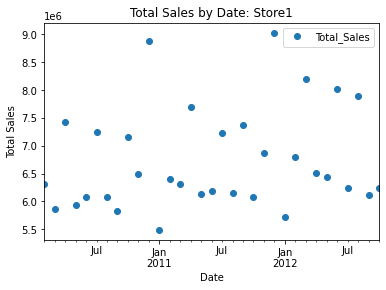

In [15]:
STORE_1.plot(x='Date', y='Total_Sales', style='o')
plt.title('Total Sales by Date: Store1')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

c:\Users\mike_\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total_Sales', ylabel='Density'>

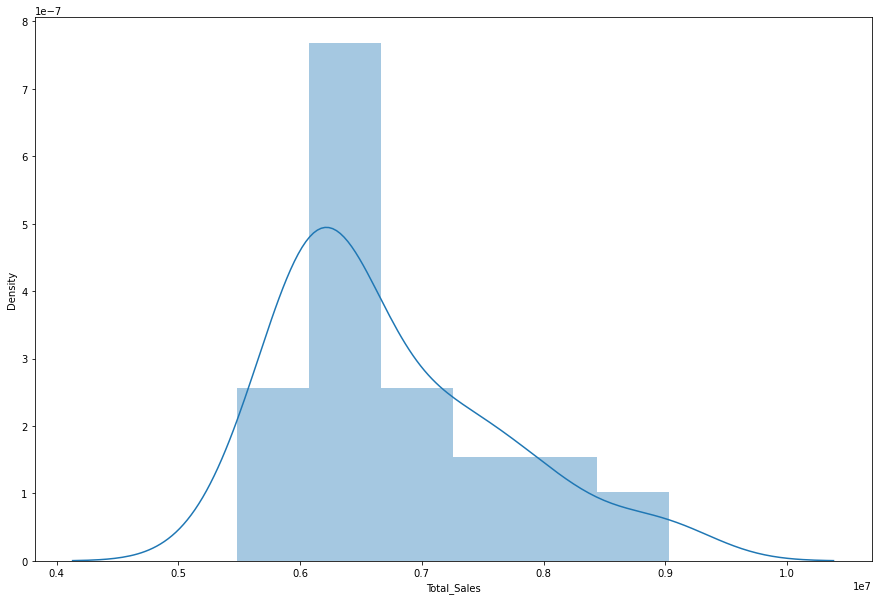

In [16]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(STORE_1['Total_Sales'])

In [17]:
#attributes and labels
X = STORE_1['Date'].values.reshape(-1,1)
y = STORE_1['Total_Sales'].values.reshape(-1,1)

In [18]:
# split 80% of the data to the training set while 20% of the data to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
# Training
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression()

In [20]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[-2617086.92717943]
[[7.13675034e-12]]


In [21]:
# use test data to see how accurately the algo predicts the pctg score
y_pred = regressor.predict(X_test)

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)

In [22]:
#timesteps
STORE_1_SERIES = STORE_1.copy()
STORE_1_SERIES['Time'] = np.arange(len(STORE_1.index))
STORE_1_SERIES.head()

,Date,Store,Total_Sales,Growth_Rate,Time
0,2010-02-28,1,6308207.10,NaN,0
45,2010-03-31,1,5871991.98,0.874486,1
90,2010-04-30,1,7422801.92,1.394436,2
135,2010-05-31,1,5929938.64,0.489827,3
180,2010-06-30,1,6084081.46,0.950426,4


In [23]:
# Training data
X = STORE_1_SERIES.loc[:, ['Time']]  # features
y = STORE_1_SERIES.loc[:, 'Total_Sales']  # target

## dividir con trai, test split

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

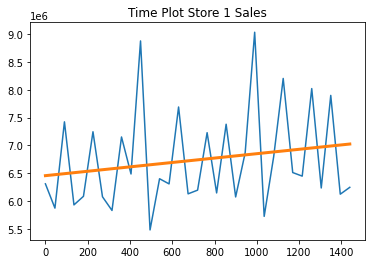

In [24]:
ax = y.plot()
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot Store 1 Sales');

### 4.2 Forecast RNN

### 4.3 Prophet

The training dataset has 28 records, ranging from 2011-01-31 00:00:00 to 2011-12-31 00:00:00
The testing dataset has 5 records, ranging from 2012-09-30 00:00:00 to 2012-06-30 00:00:00


NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


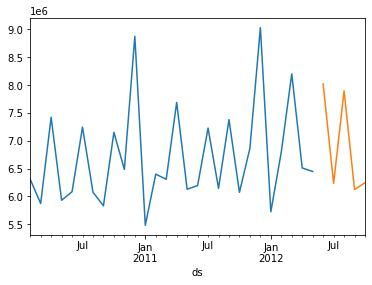

In [149]:

#First the Store 1 Monthly Sales, then for all Stores
_STORE_1_SERIES = MONTHLY_SALES_BY_STORE_W_RATE[MONTHLY_SALES_BY_STORE_W_RATE['Store']==1] #filter Store1
STORE_1_SERIES = _STORE_1_SERIES[['Date', 'Total_Sales']].rename(columns={'Date':'ds', 'Total_Sales':'y'})\
                                                         .reset_index()\
                                                         .drop(['index'], axis=1) # create Store1 table
#STORE_1_SERIES.head(10)
#STORE_1_SERIES.info()

#https://medium.com/@Hong_Tang/timeseries-split-with-sklearn-tips-8162c83612b9

# Time Series Split
tscv = TimeSeriesSplit() # instantiate object from class

STORE_1_SERIES.set_index('ds', inplace=True) # set date as index
STORE_1_SERIES.sort_index(inplace=True) # sort ascending

#prepare features dataframe (X) and target (y) as data series
X = STORE_1_SERIES.drop(labels=['y'], axis=1)
y = STORE_1_SERIES['y']

# Split train test sets for both features and targets time-series class (tscv) class returns two arrays to mark train and test sets
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Result After the split, we can check the X_train and X_test data sets
# X_test index are younger than X_train
# X_test is greater than 2012 and X_train is older than 2012.
#X_train.index, X_test.index, y_train.index, y_test.index
#X_train, X_test, y_train, y_test

# Plot results
y_train.groupby('ds').mean().plot()
y_test.groupby('ds').mean().plot()

# Summary of Train Test Split: number of records and date range for training and testing dataset.
print('The training dataset has', len(X_train), 'records, ranging from', y_train.idxmin(), 'to', y_train.idxmax())
print('The testing dataset has', len(X_test), 'records, ranging from', y_test.idxmin(), 'to', y_test.idxmax())

#rmse results list
rmse = []

# arma model
arma_model = ARMA(y_train.values, order=(0,1)).fit() # fit arma model with trian dataset
predictions = model.predict(y_test.index.values[0], y_test.index.values[-1])
true_values = y_test.values
rmse.append(np.sqrt(metrics.mean_squared_error(true_values, predictions)))
print(np.mean(rmse))

In [ ]:
#fit the model by instantiating a new Prophet object. Call fit method and pass in the historical dataframe STORE_1_SERIES
m = Prophet()
m.fit(STORE_1_SERIES)

In [74]:
# Bring graph of Store 1 data
fig = px.line(STORE_1_SERIES, x='ds', y="y",
              labels={
                'ds':'',
                'y':'Sales'
              },
              title='Store 1 Monthly Sales')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
"""# Train test split Manual
df_train = df[df['ds']<='2019-11-30']
df_test = df[df['ds']>'2019-11-30']
# Print the number of records and date range for training and testing dataset.
print('The training dataset has', len(df_train), 'records, ranging from', df_train['ds'].min(), 'to', df_train['ds'].max())
print('The testing dataset has', len(df_test), 'records, ranging from', df_test['ds'].min(), 'to', df_test['ds'].max())"""

In [27]:
#fit the model by instantiating a new Prophet object. Call fit method and pass in the historical dataframe STORE_1_SERIES
m = Prophet()
m.fit(STORE_1_SERIES)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [28]:
""" 
redictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made
You can get a suitable dataframe that extends into the future a specified number of days using the helper
method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.
"""

future = m.make_future_dataframe(periods=12, freq='M') # predict next 12 months
future.tail(15)

,ds
30,2012-08-31
31,2012-09-30
32,2012-10-31
33,2012-11-30
34,2012-12-31
35,2013-01-31
36,2013-02-28
37,2013-03-31
38,2013-04-30
39,2013-05-31


In [29]:
"""
The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical
 dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast,
  as well as columns for components and uncertainty intervals.
"""
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,yhat,yhat_lower,yhat_upper
40,2013-06-30,7.635175e+06,7.281907e+06,8.009332e+06
41,2013-07-31,7.114679e+06,6.731136e+06,7.489954e+06
42,2013-08-31,7.595596e+06,7.221252e+06,7.949448e+06
43,2013-09-30,6.691772e+06,6.332618e+06,7.058914e+06
44,2013-10-31,6.966730e+06,6.606001e+06,7.326922e+06


In [30]:
forecast.sample(9)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
25,2012-03-31,6.960121e+06,7.557607e+06,8.300292e+06,6.960121e+06,6.960121e+06,9.643833e+05,9.643833e+05,9.643833e+05,9.643833e+05,9.643833e+05,9.643833e+05,0.0,0.0,0.0,7.924504e+06
13,2011-03-31,6.693699e+06,5.751293e+06,6.470052e+06,6.693699e+06,6.693699e+06,-5.884648e+05,-5.884648e+05,-5.884648e+05,-5.884648e+05,-5.884648e+05,-5.884648e+05,0.0,0.0,0.0,6.105234e+06
14,2011-04-30,6.715537e+06,7.627220e+06,8.351282e+06,6.715537e+06,6.715537e+06,1.285425e+06,1.285425e+06,1.285425e+06,1.285425e+06,1.285425e+06,1.285425e+06,0.0,0.0,0.0,8.000962e+06
34,2012-12-31,7.160302e+06,9.426881e+06,1.014724e+07,7.160301e+06,7.160302e+06,2.613369e+06,2.613369e+06,2.613369e+06,2.613369e+06,2.613369e+06,2.613369e+06,0.0,0.0,0.0,9.773670e+06
17,2011-07-31,6.782506e+06,7.189579e+06,7.912734e+06,6.782506e+06,6.782506e+06,7.576076e+05,7.576076e+05,7.576076e+05,7.576076e+05,7.576076e+05,7.576076e+05,0.0,0.0,0.0,7.540114e+06
5,2010-07-31,6.516801e+06,6.453627e+06,7.144379e+06,6.516801e+06,6.516801e+06,2.785097e+05,2.785097e+05,2.785097e+05,2.785097e+05,2.785097e+05,2.785097e+05,0.0,0.0,0.0,6.795311e+06
38,2013-04-30,7.247653e+06,6.998463e+06,7.693918e+06,7.247652e+06,7.247654e+06,9.264711e+04,9.264711e+04,9.264711e+04,9.264711e+04,9.264711e+04,9.264711e+04,0.0,0.0,0.0,7.340300e+06
35,2013-01-31,7.182867e+06,5.042097e+06,5.763632e+06,7.182867e+06,7.182868e+06,-1.793644e+06,-1.793644e+06,-1.793644e+06,-1.793644e+06,-1.793644e+06,-1.793644e+06,0.0,0.0,0.0,5.389223e+06
0,2010-02-28,6.405417e+06,5.869952e+06,6.624020e+06,6.405417e+06,6.405417e+06,-1.567399e+05,-1.567399e+05,-1.567399e+05,-1.567399e+05,-1.567399e+05,-1.567399e+05,0.0,0.0,0.0,6.248677e+06


In [31]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          45 non-null     datetime64[ns]
 1   trend                       45 non-null     float64       
 2   yhat_lower                  45 non-null     float64       
 3   yhat_upper                  45 non-null     float64       
 4   trend_lower                 45 non-null     float64       
 5   trend_upper                 45 non-null     float64       
 6   additive_terms              45 non-null     float64       
 7   additive_terms_lower        45 non-null     float64       
 8   additive_terms_upper        45 non-null     float64       
 9   yearly                      45 non-null     float64       
 10  yearly_lower                45 non-null     float64       
 11  yearly_upper                45 non-null     float64       
 

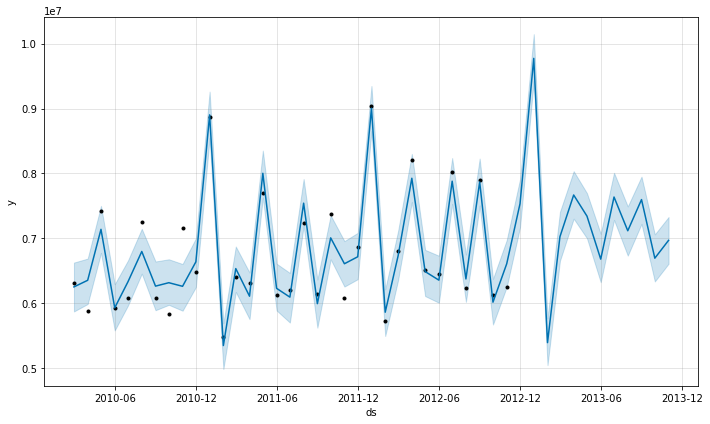

In [32]:
fig1 = m.plot(forecast)

c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



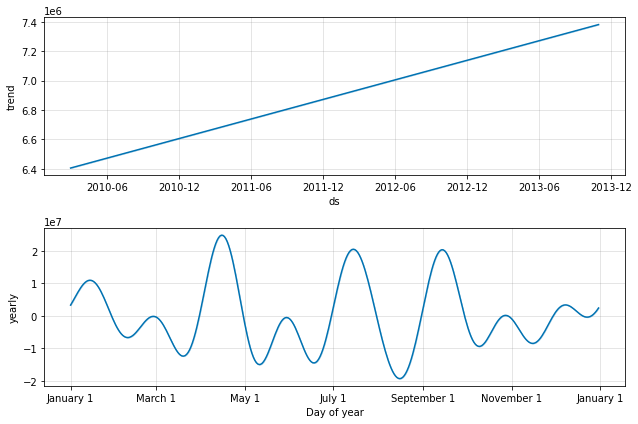

In [33]:
fig2 = m.plot_components(forecast)

In [34]:
fig3 = plot_plotly(m, forecast)
fig3

## ++++   Histórico de Ventas

In [35]:
"""

fig = px.line(df, x='Date', y="Weekly_Sales")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

"""

'\n\nfig = px.line(df, x=\'Date\', y="Weekly_Sales")\n\nfig.update_xaxes(\n    rangeslider_visible=True,\n    rangeselector=dict(\n        buttons=list([\n            dict(count=1, label="1m", step="month", stepmode="backward"),\n            dict(count=6, label="6m", step="month", stepmode="backward"),\n            dict(count=1, label="YTD", step="year", stepmode="todate"),\n            dict(count=1, label="1y", step="year", stepmode="backward"),\n            dict(step="all")\n        ])\n    )\n)\nfig.show()\n\n'

# Next Steps:
## Apply for several models: Semanal a nivel tienda

In [36]:
# por cada modelo aplicar:
results = {}
results_metrics = {}
for store in df.Store.unique():
    store_series = df[df['Store'] == store]
    results[store] = # guardar modelo creado previamente
    results_metrics[store] = #guardar metricas+performance

    ## formato con pandas


#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

# https://scikit-learn.org/stable/modules/model_evaluation.html

# rmse, mae, mse, mape <- metricas de evaluacion modelos de regresion

# adicional: evaluar modelo en train y test: métricas similares esperadas

# https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

# https://www.kdnuggets.com/2019/03/beginners-guide-linear-regression-python-scikit-learn.html

# https://www.alpharithms.com/predicting-stock-prices-with-linear-regression-214618/

SyntaxError: invalid syntax (343423073.py, line 6)